In [ ]:
Общая идея. В прошлых контестах лучшие результаты у меня показывал  градиентный бустинг, а именно xgboost. 
Поэтому первым решил попробовать его. Публичный скор более-менее сразу получился отличным (5 место под конец соревнования), 
поэтому модель не менял, решил сконцентрироваться на ее параметрах и обработке данных.

Работа с данными. В комментариях в ноутбуке написал более подробно. Кратко продублирую тут, что сделал.
Попробовал два варианта обработки имен, либо просто удалить, либо оставить, объединив редкие имена в отдельную группу (возможная корреляция между именами и социальными классами?). 
Кажется, вариант с полным удалением показал у меня чуть лучший скор. Сон обрабатывал подробно, потому что знаю, что он достаточно сильно связан с депрессией. 
Ручками интерпретировал некоторые редкие результаты, а оставшиеся обьеденил в отдельную группу. Образование, города, Dietary habits обработал просто обьединив редкие значения. 
Еще там есть фичи типа Working pressure и Academic Pressure, которые уникальны для трудящихся и студентов. 
По-хорошему в таких случаях нужно тренировать две разные модели для одних и для других, 
но я решил поступить по-простому и обьединил данные, как смог (Как раз потому, что они были уникальные я просто склеял похожие по смыслу вещи). 
Например General pressure = Academic pressure + Work pressure. Возраст был самой главной фичой на графике feature importance,
поэтому пробовал вводить явные группы возрастов в соответствие с графиком Partial dependence, не помогло или даже сделало хуже. 
Пропуски заполнял более-менее средним, медиану не пробовал, подумал, что это не важно.

Работа с моделями. Я пробовал только xgboost, но расскажу, какие еще были мысли. 
Конечно, можно было бы попробовать другие градиентные бустинги, Catboost, LightGBM, ввести голосование. 
Жалею, что не попробовал две различные модели для трудящихся и студентов, почему-то думаю, что это оказало бы хорошее влияние. 
Более простые модели не рассматривал, хотя кто знает, может они бы тоже помогли. 

Выбор модели и гиперпараметров. Про выбор модели рассказал, гиперпараметры выбирал стандартным образом, сначала тренировал на большой сетке параметров,
а дальше уточнял лучшие значения. Интересно, что я получил оптимальное значение max_depth=2. 
То есть у нас все деревья были очень маленькие и простые. Как это интерпретировать не очень понимаю. 
Может, в смысле того, что какие-то сложные модели тут не нужны. При этом никакая регуляризация мне не помогала, в этом смысле переобучения не было.

In [31]:
# Обьединим данные для обработки

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data['IsTrain'] = 1
test_data['IsTrain'] = 0
test_data['Depression'] = np.nan  

combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Посмотрим на баланс классов
print(train_data['Depression'].value_counts()) 
print(train_data['Depression'].value_counts()[0]/train_data['Depression'].value_counts()[1])

Depression
0    115133
1     25567
Name: count, dtype: int64
4.503187702898267


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
import warnings
import sklearn
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

In [32]:
# Обработка имен

# Изначально подумал, что имена нужно удалить, но потом попробовал их оставить, отчистив от редких имен (то что в осталось в комменте)
# (возможно имена каким-либо образом коррелируют с социальными классами?) 
# В итоге вариант без имен показал скор получше (или мне показалось)
'''
print(combined_data['Name'].value_counts())

name_counts = combined_data['Name'].value_counts()
rare_names = name_counts[name_counts < 100].index
combined_data['Name'] = combined_data['Name'].replace(rare_names, 'Other')

print(combined_data['Name'].value_counts())
'''

# Удалим имена
combined_data = combined_data.drop(columns=['Name']) 

In [35]:
# Обработка сна. 
# Тут я подумал, что нужно подробно обработать эту фичу, ведь известно, что между сном и депрессией есть связь.

# Тут я ручками интерпретировал некоторые ответы, их не так много
little_sleep =['0', '20-21 hours', '1-2 hours', '3-4 hours', '4-5 hours', '2-3 hours', '1-6 hours', '3-6 hours', 'than 5 hours', '1-3 hours', '1-2 hours ']
sleep56 =['4-6 hours', '6-7 hours', '6 hours', '35-36 hours', '40-45 hours']
sleep78 = ['6-8 hours', '9-5 hours', '45-48 hours']
bigsleep = ['9-10 hours', '50-75 hours', '8-89 hours', '60-65 hours', '45', '8-9 hours ', '8-9 hours', '9-11 hours', '10-11 hours', '10-6 hours', '9-5', '49 hours', '55-66 hours', '8 hours' , '9-6 hours']

combined_data['Sleep Duration'] = combined_data['Sleep Duration'].replace(little_sleep, 'Less than 5 hours')
combined_data['Sleep Duration'] = combined_data['Sleep Duration'].replace(sleep78, '7-8 hours')
combined_data['Sleep Duration'] = combined_data['Sleep Duration'].replace(bigsleep, 'More than 8 hours')
combined_data['Sleep Duration'] = combined_data['Sleep Duration'].replace(sleep56, '5-6 hours')

# То, что непонятно как интерпретировать заполнил средним значением сна 7-8 часов
print(combined_data["Sleep Duration"].unique()) 
sleep_counts = combined_data['Sleep Duration'].value_counts()
rare_sleep = sleep_counts[sleep_counts < 10].index
combined_data['Sleep Duration'] = combined_data['Sleep Duration'].replace(rare_sleep, '7-8 hours')


print(combined_data['Sleep Duration'].value_counts())

['More than 8 hours' 'Less than 5 hours' '5-6 hours' '7-8 hours'
 'Sleep_Duration' 'Moderate' 'Indore' 'No' 'Unhealthy' 'Work_Study_Hours'
 'Pune' 'Meerut' 'Vivan' 'Have_you_ever_had_suicidal_thoughts']
Sleep Duration
Less than 5 hours    64499
7-8 hours            61485
More than 8 hours    54945
5-6 hours            53571
Name: count, dtype: int64


In [36]:
# Обработка Degree

# Тут просто обьединил редкие значения
degree_counts = combined_data['Degree'].value_counts()
rare_degrees = degree_counts[degree_counts < 15].index
combined_data['Degree'] = combined_data['Degree'].replace(rare_degrees, 'Other')

print(combined_data['Degree'].value_counts())
print(combined_data["Degree"].unique()) 

Degree
Class 12    24541
B.Ed        19453
B.Arch      14779
B.Com       13552
B.Pharm      9843
BCA          9608
M.Ed         9375
MCA          8672
BBA          8417
BSc          8341
MSc          7975
LLM          7780
M.Pharm      7532
M.Tech       7492
B.Tech       7310
LLB          7286
BHM          7081
MBA          6288
BA           6240
ME           6023
MD           5672
MHM          5435
BE           5270
M.Com        5222
PhD          5176
MBBS         5115
MA           4820
Other         198
Name: count, dtype: int64
['BHM' 'LLB' 'B.Pharm' 'BBA' 'MCA' 'MD' 'BSc' 'ME' 'B.Arch' 'BCA' 'BE'
 'MA' 'B.Ed' 'B.Com' 'MBA' 'M.Com' 'MHM' 'BA' 'Class 12' 'M.Tech' 'PhD'
 'M.Ed' 'MSc' 'B.Tech' 'LLM' 'MBBS' 'M.Pharm' 'Other' nan]


In [38]:
# Обработка городов 

# Подумал, что, конечно, города будут иметь значение для модели. Бывают города обеспеченные и не очень, разная экология и тд
# Даже была идея выделить некоторые города в группы в соответствие с их богатством, но стало лень.
# Снова обьединил редкие города в отдельную группу
city_counts = combined_data['City'].value_counts()
rare_cities = city_counts[city_counts < 10].index
combined_data['City'] = combined_data['City'].replace(rare_cities, 'Other')

print(combined_data['City'].value_counts())
print(combined_data["City"].unique()) 

City
Kalyan           10978
Patna             9812
Vasai-Virar       9662
Kolkata           9415
Ahmedabad         9290
Meerut            9189
Ludhiana          8771
Rajkot            8657
Srinagar          8621
Visakhapatnam     8592
Pune              8528
Mumbai            8095
Indore            7912
Agra              7873
Vadodara          7737
Surat             7726
Varanasi          7658
Hyderabad         7619
Kanpur            7376
Jaipur            7202
Lucknow           7140
Thane             7124
Nagpur            6957
Bangalore         6830
Chennai           6718
Delhi             6129
Ghaziabad         6106
Bhopal            5845
Faridabad         5464
Nashik            5326
Other              148
Name: count, dtype: int64
['Ludhiana' 'Varanasi' 'Visakhapatnam' 'Mumbai' 'Kanpur' 'Ahmedabad'
 'Thane' 'Nashik' 'Bangalore' 'Patna' 'Rajkot' 'Jaipur' 'Pune' 'Lucknow'
 'Meerut' 'Agra' 'Surat' 'Faridabad' 'Hyderabad' 'Srinagar' 'Ghaziabad'
 'Kolkata' 'Chennai' 'Kalyan' 'Nagpur' 'Va

In [39]:
# Обработка работ

print(combined_data.isnull().sum())

# Добавил студентам в графу работ значение "student", там было пусто.
# По-хорошему, конечно, нужно было завести две разные модели для студентов и рабочих, но этот простой вариант обработки уже показал хороший результат.

mask = (combined_data["Working Professional or Student"] == "Student")
combined_data.loc[mask, "Profession"] = "Student"

# Обьединил редкие работы
job_counts = combined_data['Profession'].value_counts()
rare_jobs = job_counts[job_counts < 10].index
combined_data['Profession'] = combined_data['Profession'].replace(rare_jobs, 'Other')

print(combined_data['Profession'].value_counts())
print(combined_data["Profession"].unique())

id                                            0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                61262
Academic Pressure                        187836
Work Pressure                             46696
CGPA                                     187836
Study Satisfaction                       187836
Job Satisfaction                          46684
Sleep Duration                                0
Dietary Habits                                9
Degree                                        4
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                93800
IsTrain                                       0
dtype: int64
Profession
Student         

In [41]:
# Обработаем разницу в студентах и рабочих

# Для рабочих ввел среднюю оценку -1, кажется, так делают в таких случаях
combined_data["CGPA"] = combined_data["CGPA"].fillna(-1)

# Создаем новые объединенные признаки.
# Обьединил колонки Academic Pressure и Work Pressure в General Pressure
combined_data['General_Pressure'] = np.where(
    combined_data['Working Professional or Student'] == 'Student',
    combined_data['Academic Pressure'],
    combined_data['Work Pressure']
)

# Обьединил колонки Study Satisfaction и Job Satisfaction в General_Satisfaction
combined_data['General_Satisfaction'] = np.where(
    combined_data['Working Professional or Student'] == 'Student',
    combined_data['Study Satisfaction'],
    combined_data['Job Satisfaction']
)

combined_data = combined_data.drop(
    columns=[
        'Academic Pressure', 
        'Work Pressure',
        'Study Satisfaction', 
        'Job Satisfaction'
    ]
)
print(combined_data)

            id  Gender   Age           City Working Professional or Student  \
0            0  Female  49.0       Ludhiana            Working Professional   
1            1    Male  26.0       Varanasi            Working Professional   
2            2    Male  33.0  Visakhapatnam                         Student   
3            3    Male  22.0         Mumbai            Working Professional   
4            4  Female  30.0         Kanpur            Working Professional   
...        ...     ...   ...            ...                             ...   
234495  234495  Female  49.0         Jaipur            Working Professional   
234496  234496    Male  29.0      Ahmedabad            Working Professional   
234497  234497    Male  24.0  Visakhapatnam                         Student   
234498  234498  Female  23.0         Kalyan            Working Professional   
234499  234499  Female  43.0       Varanasi            Working Professional   

                    Profession  CGPA     Sleep Dura

In [42]:
# Обработка возраста

# Здесь я посмотрел на график Feature importance, который показал, что возраст имеет огромное значение на депрессию.
# Решил обьединить возраст в группы в соответствие с графиком Partial dependance, может это помогло бы модели
# Конечно, это не помогло, а сделало хуже

'''
print(combined_data['Age'].value_counts())
print(combined_data["Age"].unique())
bins = [0, 22, 32, 44, 53, 150]  # Границы интервалов
labels = ['Very Young', 'Young', 'Medium', 'Old', 'Very Old']  # Метки


combined_data['Age type'] = pd.cut(combined_data['Age'], bins=bins, labels=labels, right=False)

print(combined_data)
'''

'\nprint(combined_data[\'Age\'].value_counts())\nprint(combined_data["Age"].unique())\nbins = [0, 22, 32, 44, 53, 150]  # Границы интервалов\nlabels = [\'Very Young\', \'Young\', \'Medium\', \'Old\', \'Very Old\']  # Метки\n\n\ncombined_data[\'Age type\'] = pd.cut(combined_data[\'Age\'], bins=bins, labels=labels, right=False)\n\nprint(combined_data)\n'

In [44]:
# Обработает Dietary Habits


# Ручками интерпретировал некоторые редкие ответы
healthy =['More Healthy', '5 Healthy']
unhealthy = ['Less Healthy', '5 Unhealthy', 'No Healthy']

combined_data['Dietary Habits'] = combined_data['Dietary Habits'].replace(healthy, 'Healthy')
combined_data['Dietary Habits'] = combined_data['Dietary Habits'].replace(unhealthy, 'Unhealthy')

print(combined_data['Dietary Habits'].value_counts())
print(combined_data["Dietary Habits"].unique()) 

# Оставшиеся редкие убрал, заменив на среднее значение
diet_counts = combined_data['Dietary Habits'].value_counts()
rare_diets = diet_counts[diet_counts < 10].index
combined_data['Dietary Habits'] = combined_data['Dietary Habits'].replace(rare_diets, 'Moderate')

print(combined_data['Dietary Habits'].value_counts())
print(combined_data["Dietary Habits"].unique()) 

Dietary Habits
Moderate             82723
Unhealthy            77017
Healthy              74712
No                       8
Indoor                   2
1.0                      2
Yes                      2
Male                     2
2                        1
Naina                    1
Raghav                   1
Vivaan                   1
Soham                    1
Educational              1
Academic                 1
MCA                      1
Resistant                1
Mealy                    1
Prachi                   1
Pratham                  1
Class 12                 1
BSc                      1
Vegas                    1
M.Tech                   1
Electrician              1
Hormonal                 1
Mihir                    1
Less than Healthy        1
3                        1
Gender                   1
Kolkata                  1
Name: count, dtype: int64
['Healthy' 'Unhealthy' 'Moderate' 'Yes' 'Pratham' 'BSc' 'Gender' '3'
 'Less than Healthy' 'Mihir' '1.0' 'Hormonal' 'Electr

In [45]:
print(combined_data.isnull().sum())

# заполним пропуски средним значением или типа того
combined_data["Profession"] = combined_data["Profession"].fillna("No job")
combined_data["Dietary Habits"] = combined_data["Dietary Habits"].fillna("Moderate")
combined_data["Degree"] = combined_data["Degree"].fillna("Unknown")
combined_data["Financial Stress"] = combined_data["Financial Stress"].fillna(combined_data["Financial Stress"].median())
combined_data["General_Pressure"] = combined_data["General_Pressure"].fillna(combined_data["General_Pressure"].median())
combined_data["General_Satisfaction"] = combined_data["General_Satisfaction"].fillna(combined_data["General_Satisfaction"].median())
print(combined_data.isnull().sum())

id                                           0
Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               14649
CGPA                                         0
Sleep Duration                               0
Dietary Habits                               9
Degree                                       4
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             4
Family History of Mental Illness             0
Depression                               93800
IsTrain                                      0
General_Pressure                            46
General_Satisfaction                        44
dtype: int64
id                                           0
Gender                                       0
Age                                          0


In [49]:
# использую самый простой вариант one-hot-encoding
categorical_features = ['Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
combined_data = pd.get_dummies(combined_data, columns=categorical_features) # Воспользуемся простым методом

train_data_processed = combined_data[combined_data['IsTrain'] == 1].drop('IsTrain', axis=1)
test_data_processed = combined_data[combined_data['IsTrain'] == 0].drop(['IsTrain', 'Depression'], axis=1)

X_train = train_data_processed.drop(['Depression', 'id'], axis=1)
y_train = train_data_processed['Depression'].astype(int)
X_test = test_data_processed.drop('id', axis=1)




Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters found on development set:
{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 250}

Grid scores on development set:
0.939 +- 0.002 for {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 250}
Cross-validation accuracy: 0.939 (+/- 0.002)


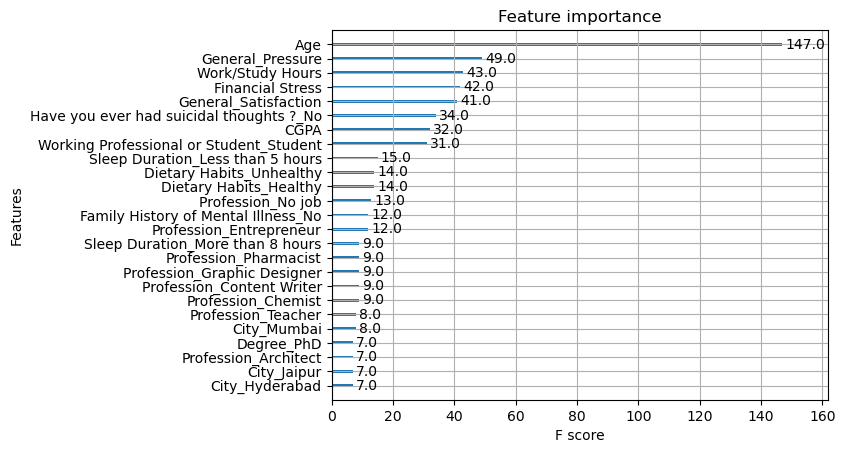

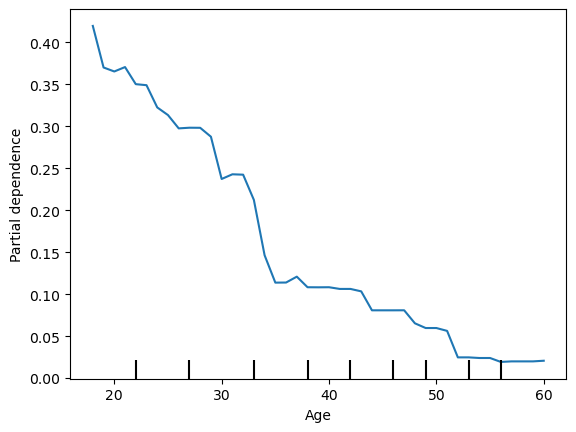

In [51]:
# Решил использовать xgboost, потому что в предыдущем контесте он показал самый хороший скор...

FOLD_K = 4

xgb_model = XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    eval_metric='error', 
    random_state=42,
)

# Изначально использовал большую сетку параметров, в том числе и с регуляризацией, оставил ее в комменте

'''
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'learning_rate': [0.2, 0.1, 0.3, 0.5],
    'max_depth': [2, 3, 5, 7, 9],
    'reg_lambda': [0.001, 0, 0.01, 0.1],
    'reg_alpha': [0.001, 0, 0.01, 0.1],
}
'''

# А это то, что показало лучший результат на паблике. Интересно, что глубина дерева тут всего лишь 2.
param_grid = {
    'n_estimators': [250],
    'learning_rate': [0.2],
    'max_depth': [2],
}


skf = StratifiedKFold(n_splits=FOLD_K, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found on development set:")
print(grid_search.best_params_)
print()

print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f +- %0.3f for %r" % (mean, std * 2, params))


best_model = grid_search.best_estimator_

# Порождаем и сохраняем сабмит
X_test = test_data_processed.drop('id', axis=1)
y_pred = best_model.predict(X_test)

submission = pd.DataFrame({
    'id': test_data['id'],
    'Depression': y_pred 
})

submission.to_csv('submission.csv', index=False)

cv_scores = cross_val_score(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=FOLD_K,
    scoring='accuracy'
)
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")


# Решил посмотреть на feature importance, видно, что возраст имеет определяющее значение.
plot_importance(best_model, max_num_features=25)
plt.show()

# Тут посмотрел на Partial dependence фич
features = [0]  # Индексы признаков для анализа, то есть возраст.
PartialDependenceDisplay.from_estimator(best_model, X_train, features)
plt.show()